In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 5s 122ms/step - loss: 0.0306 - val_loss: 0.0072
Epoch 2/100
18/18 [==============================] - 2s 100ms/step - loss: 0.0050 - val_loss: 7.5949e-04
Epoch 3/100
18/18 [==============================] - 2s 107ms/step - loss: 0.0014 - val_loss: 3.9595e-04
Epoch 4/100
18/18 [==============================] - 2s 118ms/step - loss: 8.5215e-04 - val_loss: 4.0704e-04
Epoch 5/100
18/18 [==============================] - 2s 106ms/step - loss: 7.6581e-04 - val_loss: 3.8878e-04
Epoch 6/100
18/18 [==============================] - 2s 84ms/step - loss: 7.0835e-04 - val_loss: 3.8675e-04
Epoch 7/100
18/18 [==============================] - 1s 83ms/step - loss: 6.8399e-04 - val_loss: 3.8550e-04
Epoch 8/100
18/18 [==============================] - 1s 76ms/step - loss: 6.6054e-04 - val_loss: 3.5256e-04
Epoch 9/100
18/18 [==============================] - 1s 76ms/step - loss: 6.4085e-04 - val_loss: 3.7050e-04
Epoch 10/100
18/18 [===================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 19ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 18208.5665811537


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99838483514525
Testing MAE: 18083.24301725157


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.3219240605831146], [0.32101014256477356], [0.31891652941703796], [0.31640246510505676], [0.3136613965034485], [0.3107733130455017], [0.30777519941329956], [0.3046892285346985], [0.30153176188468933], [0.2983159124851227], [0.2950521409511566], [0.29174914956092834], [0.28841444849967957], [0.28505459427833557], [0.28167539834976196], [0.2782820761203766], [0.2748793363571167], [0.27147161960601807], [0.2680628001689911], [0.26465657353401184], [0.2612563371658325], [0.2578650712966919], [0.2544855773448944], [0.2511204183101654], [0.24777191877365112], [0.2444421797990799], [0.2411329448223114], [0.23784592747688293], [0.23458260297775269], [0.23134426772594452], [0.22813211381435394], [0.22494694590568542], [0.22178968787193298], [0.21866096556186676], [0.2155614048242569], [0.21249137818813324], [0.20945124328136444], [0.20644119381904602], [0.20346148312091827], [0.20051205158233643], [0.1975928544998169], [0.19470401108264923], [0.19184522330760956], [0.18901629745960236], [0.1

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[19619.57139558],
       [19583.00471314],
       [19499.23736685],
       [19398.64739107],
       [19288.97476936],
       [19173.41995093],
       [19053.46272621],
       [18929.99025398],
       [18803.65717159],
       [18674.98814285],
       [18544.40170638],
       [18412.24604817],
       [18278.82165748],
       [18144.39086621],
       [18009.18619583],
       [17873.41631944],
       [17737.26963905],
       [17600.92382489],
       [17464.53389128],
       [17328.24769801],
       [17192.20118071],
       [17056.51358114],
       [16921.29698659],
       [16786.65394497],
       [16652.67746486],
       [16519.45161172],
       [16387.04614199],
       [16255.52961968],
       [16124.96106948],
       [15995.39236156],
       [15866.87119261],
       [15739.42975794],
       [15613.10502248],
       [15487.922027  ],
       [15363.90581228],
       [15241.07128355],
       [15119.43274981],
       [14998.99796177],
       [14879.777055  ],
       [14761.76764466],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [25]:
print(y_pred_with_test_data.shape)
test_data.shape

(311,)


(311, 1)

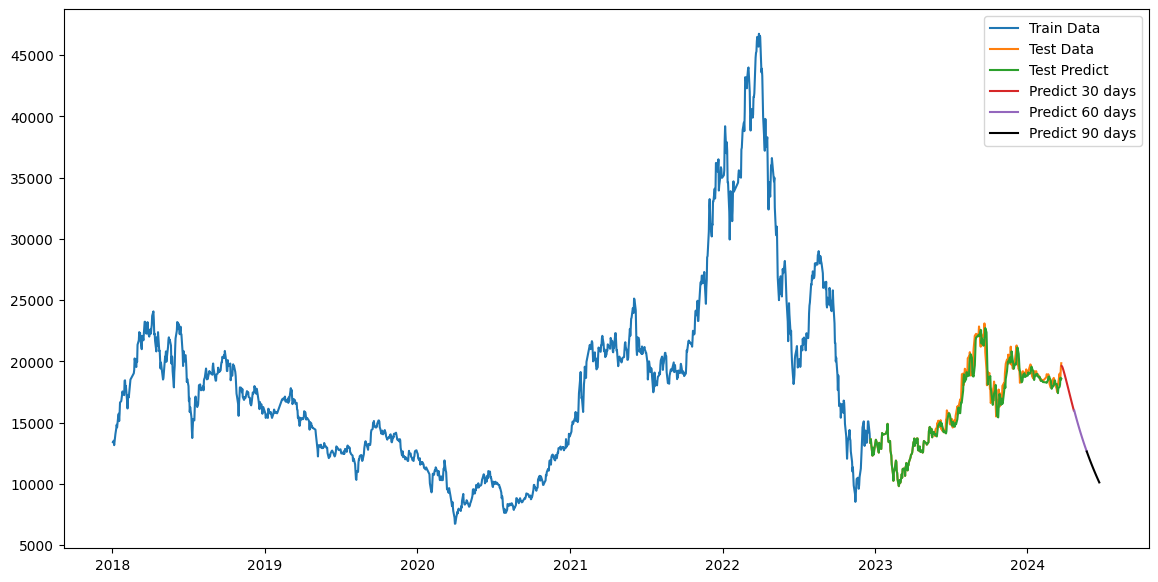

In [27]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()